In [115]:
import numpy as np
import copy
import random
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from scipy.interpolate import interp1d

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

## Реализуем поле GF(2^6) по модулю многочлена p(x)=x^6+x+1

In [6]:
def polynome_mul(a, b):
    d = i = 0
    while b > 0:
        if b & 1:
            d ^= (a << i)
        b = b >> 1
        i += 1
    return d 

In [7]:
def polynome_div(a, b):
    res = 0
    r = a.bit_length() - b.bit_length()
    while (r >= 0): 
        res += 1 << r
        a ^= b << r
        r = a.bit_length() - b.bit_length()
    return res

In [8]:
def galois_mul(a, b, base_polynome=int("1000011",2)):
    mul = polynome_mul(a, b)
    for i in range(len(bin(mul)) - 2, len(bin(base_polynome)) - 4, -1):
        if ((1 << i) & mul):
            mul ^= base_polynome << i - len(bin(base_polynome)) +3
    return int(mul)


In [9]:
def galois_add(a, b):
    return a^b

In [10]:
def find_inverse(matrix_mul ,a):
    for i in range(len(matrix_mul[int(a-1) % 63])):
        if matrix_mul[int(a-1) %63][i] == 1:
            return i+1
    return 0

In [11]:
matrix_mul = np.zeros((2**6 - 1, 2**6 -1)).astype(int)
matrix_mul[0, :] = np.arange(1, 2**6, 1).astype(int)
matrix_mul[:, 0] = np.arange(1 , 2**6, 1).astype(int)
for i in range(len(matrix_mul)):
    for j in range(len(matrix_mul)):
        matrix_mul[i][j] = galois_mul(i + 1 , j + 1)
matrix_mul

array([[ 1,  2,  3, ..., 61, 62, 63],
       [ 2,  4,  6, ..., 57, 63, 61],
       [ 3,  6,  5, ...,  4,  1,  2],
       ...,
       [61, 57,  4, ..., 46, 42, 23],
       [62, 63,  1, ..., 42, 43, 21],
       [63, 61,  2, ..., 23, 21, 42]])

In [12]:
matrix_pow = np.zeros((2**6 - 1, 2**6 -1)).astype(int)
matrix_pow[0, :] = np.arange(1, 2**6, 1).astype(int)
matrix_pow[:, 0] = np.arange(1 , 2**6, 1).astype(int)
for i in range(len(matrix_mul)):
    for j in range(1, len(matrix_pow)):
        matrix_pow[i][j] = galois_mul(i+1 ,int(matrix_pow[i][j-1]))
matrix_pow

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  4,  8, ..., 49, 33,  1],
       [ 3,  5, 15, ..., 43, 62,  1],
       ...,
       [61, 46, 43, ..., 12, 16,  1],
       [62, 43, 25, ...,  5,  3,  1],
       [63, 42, 13, ..., 48, 32,  1]])

In [13]:
matrix_add = np.zeros((2**6, 2**6)).astype(int)
matrix_add[0, :] = np.arange(2**6).astype(int)
matrix_add[:, 0] = np.arange(2**6).astype(int)
for i in range(len(matrix_add)):
    for j in range(len(matrix_add)):
        matrix_add[i][j] =  galois_add(i, j)
matrix_add

array([[ 0,  1,  2, ..., 61, 62, 63],
       [ 1,  0,  3, ..., 60, 63, 62],
       [ 2,  3,  0, ..., 63, 60, 61],
       ...,
       [61, 60, 63, ...,  0,  3,  2],
       [62, 63, 60, ...,  3,  0,  1],
       [63, 62, 61, ...,  2,  1,  0]])

##  Получаем синдром 


In [14]:
def get_syndrom(matrix_pow, v, t=13, n=63):
    res = []
    s_1 = 0
    for i in range(2 * t):
        s_1= 0
        alpha = int(matrix_pow[1][i])
        for j in range(len(v)):
            if v[j] != 0:
                s_1 ^= matrix_mul[(matrix_pow[(alpha - 1)][(j-1)%n] -1)%n ] [(v[j] -1) % n]
        res.append(s_1)
    return res

## Кодируем слово

In [15]:
def code(v, matrix_mul, matrix_pow, n=63):
    result = np.zeros(n).astype(int)
    for i in range(n):
        alpha = matrix_pow[1][i-1]
        for j in range(len(v)):
            if v[j] != 0:
                result[i] ^= matrix_mul[(v[j] - 1)%n][(matrix_pow[(alpha - 1)][(j-1)%n] -1) %n]
    return result
        
    

## Решаем систему линейных уравнений в поле

In [16]:
def solve(matrix_main, vector_main, matrix_mul, n=63):
    matrix = matrix_main.copy()
    vector = vector_main.copy()
    res = [0 for i in range(len(matrix))]
    order = [0 for i in range(len(matrix))]
    t = len(matrix)
    for k in range(1, t):
        for i in range (k, t):
            if(matrix[k-1][k - 1] == 0):
                for z in range(k-1,t):
                    if matrix[z][k-1] != 0:
                        a = matrix[k-1].copy()
                        matrix[k-1] = matrix[z].copy()
                        matrix[z] = a
                        a = vector[k-1]
                        vector[k-1] = vector[z]
                        vector[z] = a
                        break
            save = matrix[i][k - 1]
            step = matrix_mul[(find_inverse(matrix_mul,matrix[k - 1][k - 1]) - 1)%63][(save-1)%n]
            if save ==0:
                continue
            for j in range(k-1,t):
                if matrix[k -1][j]  != 0:
                    matrix[i][j] = matrix[i][j] ^ matrix_mul[(matrix[k -1][j] - 1) % n][(step -1) %n]
            if vector[k-1] != 0:
                vector[i] = vector[i] ^ matrix_mul[(vector[k-1]- 1) % n][(step -1) %n]
    for i in range(t):
        if matrix[i][i] == 0:
            return []
    for i in range(t - 1, -1, -1):
        for j in range(t):
            if(res[j] == 0 or matrix[i][j]==0):
                continue
            res[i] = res[i] ^ matrix_mul[(matrix[i][j]-1)%n][(res[j]-1)%n]
        if (vector[i] ^ res[i]) != 0:
            res[i] = matrix_mul[((vector[i] ^ res[i]) -1)%n][(find_inverse(matrix_mul,matrix[i][i]) - 1)%n]
        else:
            res[i] = 0
    return res

## Получаем матрицу локаторов ошибок

In [17]:
def make_locator_matrix(s, t=13, q=64):
    matrix_locator = np.zeros((t,t)).astype(int)
    s_r = np.zeros(t).astype(int)
    for i in range(t):
        for j in range(t):
            matrix_locator[i][j] = s[t+i-j-1]
            s_r[i] = s[t+i]
    return matrix_locator, s_r

## Находим инедксы в которых произошла ошибка

In [18]:
def get_err_indexes(matrix_locator, s_r, matrix_mul,matrix_pow, n=63):
    i = n
    roots = []
    roots_index = []
    while i > 0:
        pol_loc = solve(matrix_locator[:i,:i], s_r[:i], matrix_mul)
        if pol_loc != []:
            roots = []
            roots_index = []
            for j in range(n):
                pretend = 1
                for k in range(len(pol_loc)):
                    if pol_loc[k] !=0:
                        pretend ^= matrix_mul[(matrix_pow[j][k] -1)%n][((pol_loc[k]) -1)%n]
                if pretend == 0:
                    root = find_inverse(matrix_mul, matrix_pow[j][0])
                    roots.append(root)
                    roots_index.append(int(np.where(matrix_pow[1] == root)[0] + 1) % n)
            if len(roots) != len(pol_loc):
                roots = []
                roots_index = []
            if roots != []:
                break
        i -= 1
    return sorted(roots_index)


## Находим значения которые надо вычесть из принятого вектора чтобы получить правильное слово

In [19]:
def make_err_system(indexes, matrix_pow,t, n=63):
    size = n
    matrix = np.zeros((t,size)).astype(int)
    for i in range(t):
        alpha = int(matrix_pow[1][i])
        for j in range(size):
            if j in indexes:
                matrix[i][j] = matrix_pow[(alpha - 1)][(j-1)%n]
    return matrix

In [20]:
def get_values_to_add(err_indexes, s, matrix_mul, matrix_pow, n=63):
    res = []
    matrix = make_err_system(err_indexes, matrix_pow,len(s), n)
    ind_to_del = np.asarray(np.where(np.all(matrix == 0, axis=0) == True))
    short_matrix = np.delete(matrix, ind_to_del, axis=1)
    row_size = len(short_matrix[0])
    return  solve(short_matrix[:row_size,:row_size], s[:row_size], matrix_mul)

 ## Проведем моделирование кода

In [83]:
def modeling(matrix_pow, matrix_mul, t, p, n=63):
    v= code([random.randint(0,n) for i in range(n - 2*t)], matrix_mul, matrix_pow)
    j = 0
    v_old = v.copy()
    for i in range(len(v)):
            if random.random() < p:
                v[i]^=random.randint(1,n)
                j+=1
    s = get_syndrom(matrix_pow, v, t)
    if all(x == 0 for x in s):
            return True
    matrix_locator, s_r = make_locator_matrix(s,t)
    ind = get_err_indexes(matrix_locator, s_r,matrix_mul, matrix_pow)
    val = get_values_to_add(ind, s, matrix_mul, matrix_pow)
    for i in range(len(ind)):
        v[ind[i]] ^= val[i]
    if all(x == 0 for x in (v ^ v_old)):
            return True
    else:
        return False

## Кривые в логарифмическом масштабе

In [106]:
num_of_runs = 100
err_prob_in = np.arange(0, 0.31, 0.001)
err_prob_out = {}
err_prob_out["Соломон (63,41,23)"] =[]
err_prob_out["Соломон (63,31,33)"] =[]
err_prob_out["Соломон (63,21,43))"] =[]
err_prob_out["Соломон (63,11,53)"] =[]
erros_to_correct = [11, 16, 21, 26]
for p in tqdm(err_prob_in):
    error_count = [0,0,0,0]
    for run in (range(num_of_runs)):
        for i in range(len(erros_to_correct)):
            if not modeling(matrix_pow, matrix_mul, erros_to_correct[i], p, 63):
                error_count[i] += 1
    i = 0
    for name in err_prob_out.keys():
        err_prob_out[name].append(error_count[i] / num_of_runs)
        i += 1
    
       












  0%|          | 0/310 [00:00<?, ?it/s]










  0%|          | 1/310 [00:02<13:26,  2.61s/it]










  1%|          | 2/310 [00:13<25:50,  5.03s/it]










  1%|          | 3/310 [00:25<37:23,  7.31s/it]










  1%|▏         | 4/310 [00:49<1:01:38, 12.09s/it]










  2%|▏         | 5/310 [01:20<1:31:13, 17.95s/it]










  2%|▏         | 6/310 [01:52<1:51:18, 21.97s/it]










  2%|▏         | 7/310 [02:30<2:15:55, 26.92s/it]










  3%|▎         | 8/310 [03:05<2:27:27, 29.30s/it]










  3%|▎         | 9/310 [04:01<3:07:12, 37.32s/it]










  3%|▎         | 10/310 [04:58<3:36:40, 43.34s/it]










  4%|▎         | 11/310 [05:56<3:57:14, 47.61s/it]










  4%|▍         | 12/310 [06:58<4:18:05, 51.97s/it]










  4%|▍         | 13/310 [08:03<4:36:00, 55.76s/it]










  5%|▍         | 14/310 [09:12<4:55:12, 59.84s/it]










  5%|▍         | 15/310 [10:26<5:14:46, 64.02s/it]










  5%|▌         | 16/310 [11:41<5:30:04,

 54%|█████▍    | 168/310 [7:52:08<8:03:44, 204.40s/it]










 55%|█████▍    | 169/310 [7:55:10<7:44:28, 197.65s/it]










 55%|█████▍    | 170/310 [7:58:22<7:37:20, 196.01s/it]










 55%|█████▌    | 171/310 [9:20:06<62:06:17, 1608.47s/it]










 55%|█████▌    | 172/310 [9:23:08<45:14:58, 1180.42s/it]










 56%|█████▌    | 173/310 [9:26:10<33:31:18, 880.87s/it] 










 56%|█████▌    | 174/310 [9:29:12<25:21:23, 671.20s/it]










 56%|█████▋    | 175/310 [9:32:12<19:38:38, 523.84s/it]










 57%|█████▋    | 176/310 [9:35:15<15:41:40, 421.64s/it]










 57%|█████▋    | 177/310 [9:38:20<12:57:02, 350.55s/it]










 57%|█████▋    | 178/310 [9:41:53<11:20:24, 309.28s/it]










 58%|█████▊    | 179/310 [9:45:33<10:17:24, 282.78s/it]










 58%|█████▊    | 180/310 [9:49:21<9:36:45, 266.19s/it] 










 58%|█████▊    | 181/310 [9:53:10<9:08:08, 254.95s/it]










 59%|█████▊    | 182/310 [9:56:52<8:43:17, 245.29s/it]










 59%|█████▉ 

/Users/Silya/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


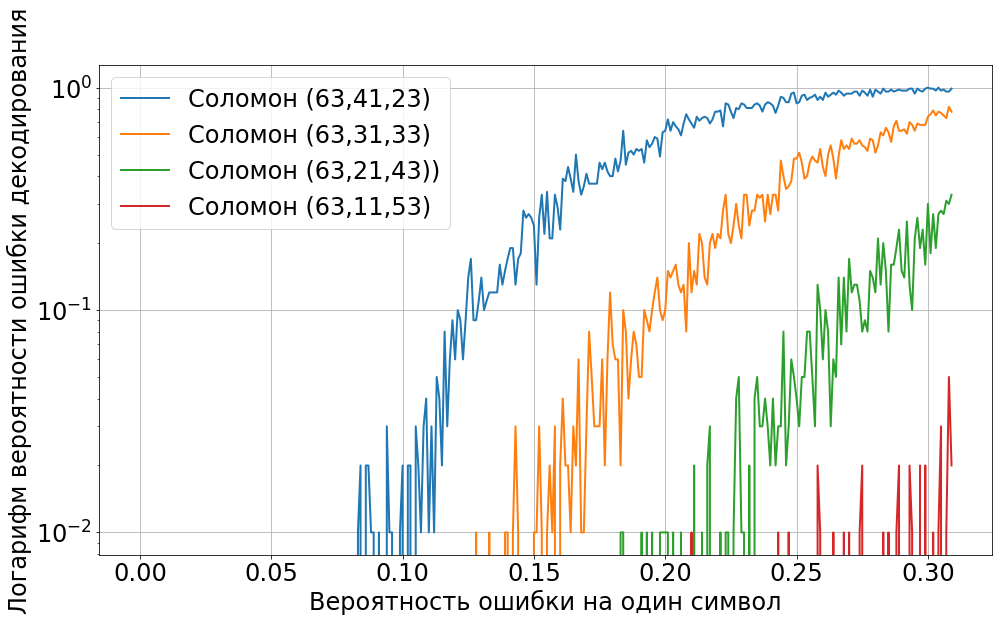

In [157]:
plt.figure(figsize=(16,9))
for name in err_prob_out.keys():
    plt.grid(1)
    plt.plot(err_prob_in, err_prob_out[name], label=name)
    plt.legend()
    plt.xlabel("Вероятность ошибки на один символ")
    plt.ylabel("Логарифм вероятности ошибки декодирования")
plt.yscale("log")

## Сгладим наши кривые

In [144]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [108]:
a = err_prob_out.copy()
b = err_prob_in.copy()

/Users/Silya/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


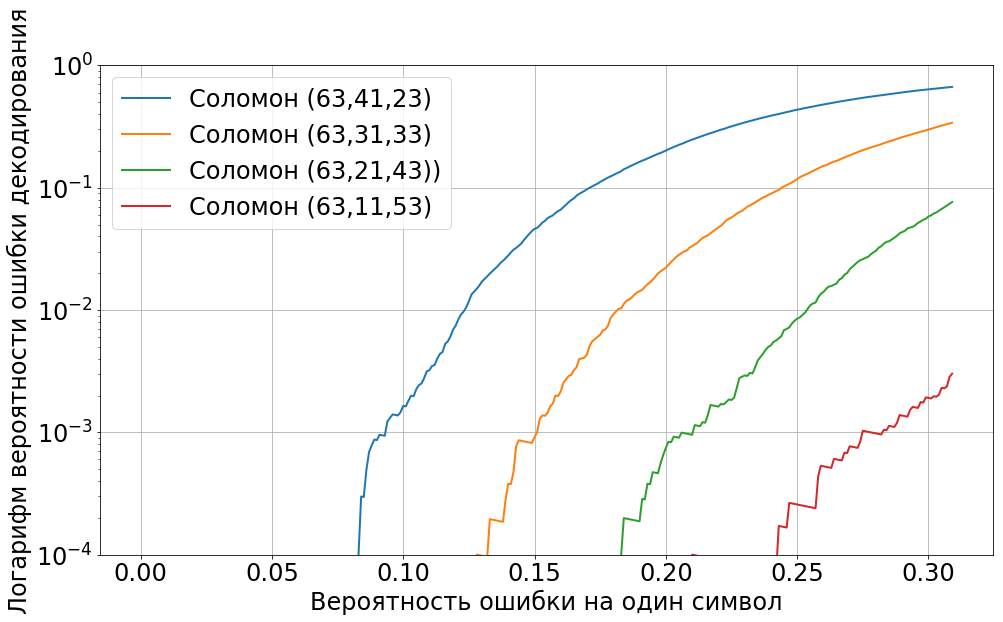

In [159]:
plt.figure(figsize=(16,9))
for i in a.keys():
    plt.plot(b, exponential_smoothing(a[i], 0.01), label=i)
    plt.legend()
    plt.xlabel("Вероятность ошибки на один символ")
    plt.ylabel("Логарифм вероятности ошибки декодирования")
    plt.legend()
    plt.grid(1)
    plt.yscale("log")
    plt.ylim(ymin=1e-4, ymax=1)

## Стандартные кривые 

In [109]:
num_of_runs = 100
err_prob_in = np.arange(0, 0.5, 0.02)
err_prob_out = {}
err_prob_out["Соломон (63,41,23)"] =[]
err_prob_out["Соломон (63,31,33)"] =[]
err_prob_out["Соломон (63,21,43))"] =[]
err_prob_out["Соломон (63,11,53)"] =[]
erros_to_correct = [11, 16, 21, 26]
for p in tqdm(err_prob_in):
    error_count = [0,0,0,0]
    for run in (range(num_of_runs)):
        for i in range(len(erros_to_correct)):
            if not modeling(matrix_pow, matrix_mul, erros_to_correct[i], p, 63):
                error_count[i] += 1
    i = 0
    for name in err_prob_out.keys():
        err_prob_out[name].append(error_count[i] / num_of_runs)
        i += 1












  0%|          | 0/25 [00:00<?, ?it/s]










  4%|▍         | 1/25 [00:03<01:15,  3.15s/it]










  8%|▊         | 2/25 [01:52<13:25, 35.01s/it]










 12%|█▏        | 3/25 [04:22<25:27, 69.43s/it]










 16%|█▌        | 4/25 [07:13<34:57, 99.89s/it]










 20%|██        | 5/25 [10:38<43:48, 131.45s/it]










 24%|██▍       | 6/25 [13:46<47:02, 148.55s/it]










 28%|██▊       | 7/25 [16:42<46:58, 156.61s/it]










 32%|███▏      | 8/25 [20:24<49:56, 176.24s/it]










 36%|███▌      | 9/25 [23:45<49:01, 183.84s/it]










 40%|████      | 10/25 [27:06<47:12, 188.85s/it]










 44%|████▍     | 11/25 [30:48<46:24, 198.90s/it]










 48%|████▊     | 12/25 [34:57<46:20, 213.89s/it]










 52%|█████▏    | 13/25 [39:17<45:31, 227.60s/it]










 56%|█████▌    | 14/25 [43:49<44:12, 241.18s/it]










 60%|██████    | 15/25 [47:24<38:52, 233.28s/it]










 64%|██████▍   | 16/25 [50:47<33:38, 224.23s/it]










 68%|████

/Users/Silya/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


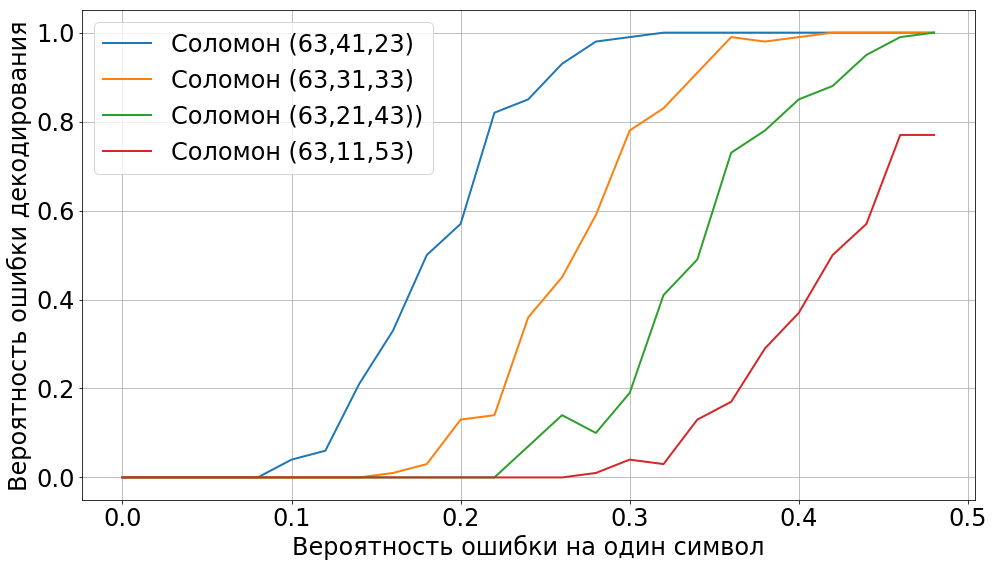

In [110]:
plt.figure(figsize=(16,9))
for name in err_prob_out.keys():
    plt.grid(1)
    plt.plot(err_prob_in, err_prob_out[name], label=name)
    plt.legend()
    plt.xlabel("Вероятность ошибки на один символ")
    plt.ylabel("Вероятность ошибки декодирования")